In [1]:

import pyscisci.all as pyscisci

import os
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pylab as plt


try:
    import seaborn as sns
    sns.set_style('white')
    
    from cdlib import algorithms
    
    from clusim.clustering import Clustering
except:
    print('This example requires the optional packages seaborn, cdlib and clusim.')
    print('Please run:')
    print('pip install seaborn cdlib clusim')
    
%matplotlib inline

In [2]:
# set this path to where the APS database will be stored
path2aps = '/home/ajgates/APS'

myaps = pyscisci.APS(path2aps, keep_in_memory=False) 

# override the default APS data with the author disambiguation
myaps.set_new_data_path('paa', 'publicationauthoraffiliation_supp2010')

In [3]:
# we need the linkages between publications and authors
paa = myaps.paa

# and we need the linkages between publications and their references
pub2ref = myaps.pub2ref

# finally, we need temporal career information so load the year mapping
pub2year = myaps.pub2year

# and add the years to the paa
paa['Year'] = [pub2year.get(pid, None) for pid in paa['PublicationId'].values]

Loading Publication Author Affiliation:   0%|          | 0/1 [00:00<?, ?it/s]

Loading pub2ref:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# Lets take the publication career of Giorgio Parisi

parisi_paa = paa[paa['FullName'] == 'giorgio..parisi']
parisi_paa.drop_duplicates(subset=['PublicationId'], inplace=True)

parisi_paa.nunique()

PublicationId          89
AuthorId                1
FullName                1
AuthorOrder             5
OrigAffiliationName    84
FirstName               1
MiddleName              0
LastName                1
Year                   22
dtype: int64

In [5]:
career_topics, cocite_network = pyscisci.career_cociting_network_topics(parisi_paa, 
                                                                        pub2ref, 
                                        randomize=42, 
                                        return_network=True, show_progress=False)

print(nx.info(cocite_network))

Graph with 67 nodes and 444 edges


In [6]:
topic_community = nx.get_node_attributes(cocite_network, 'TopicCommunity')

louvain_communities = Clustering().from_membership_list([topic_community[i] for i in range(len(topic_community))])


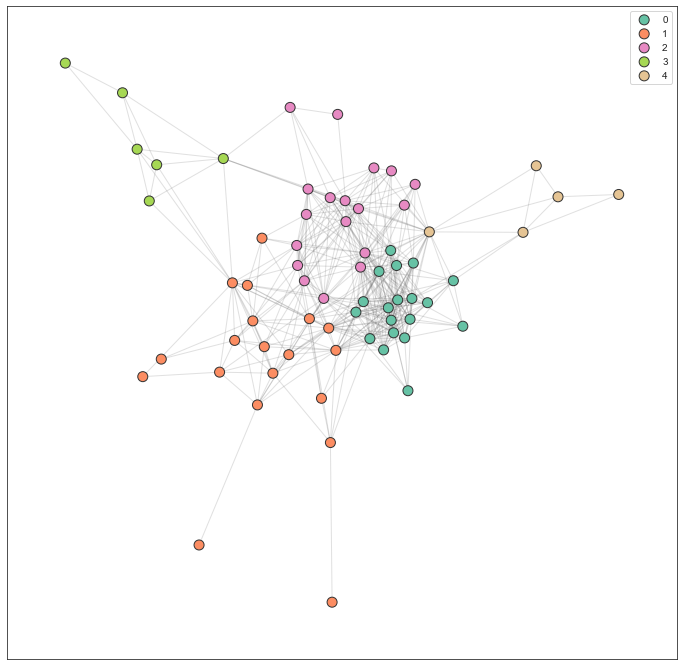

In [7]:
pos = nx.drawing.nx_agraph.graphviz_layout(cocite_network, prog='sfdp',)


fig, ax = plt.subplots(1,1,figsize=(12,12))         



nx.draw_networkx_edges(cocite_network, pos, edgelist=cocite_network.edges(),
        edge_color = '0.4',
        alpha=0.2,
        ax=ax)

for c in louvain_communities.clusters:
    nx.draw_networkx_nodes(cocite_network.subgraph(louvain_communities.clu2elm_dict[c]), pos,
        node_size= 100, 
        node_color=[c]*len(louvain_communities.clu2elm_dict[c]),
        cmap = sns.color_palette("Set2", as_cmap=True),
        edgecolors='0.2', # node outline
        vmin = 0,
        vmax = louvain_communities.n_clusters,
        label = str(c),
        ax = ax)


plt.legend()
plt.show()

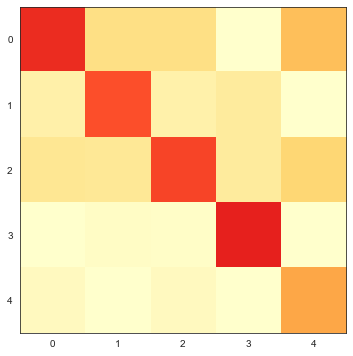

In [8]:
ncomm = louvain_communities.n_clusters
community_connectivity = np.zeros((ncomm, ncomm))

cociting_adjmat = nx.to_scipy_sparse_matrix(cocite_network)

for ic, jc in itertools.product(range(ncomm), repeat=2):
    idx = np.sort(list(louvain_communities.clu2elm_dict[ic]))
    jdx = np.sort(list(louvain_communities.clu2elm_dict[jc]))
    community_connectivity[ic,jc] = cociting_adjmat[idx][:,jdx].sum()

community_connectivity = community_connectivity/community_connectivity.sum(axis=0)

fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.imshow(community_connectivity, cmap='YlOrRd', vmin=0, vmax=1)

plt.show()

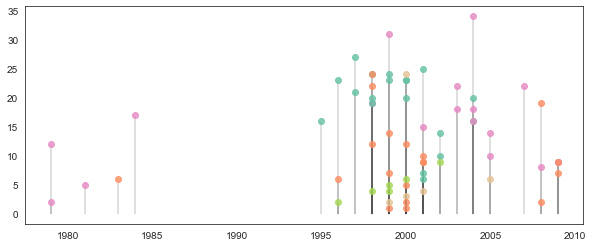

In [9]:
cmap = sns.color_palette("Set2", as_cmap=True)

fig, ax = plt.subplots(1,1,figsize=(10, 4))

for y, topic, degree in career_topics[['Year', 'TopicCommunity', 'Degree']].values:
    ax.scatter(y, degree, c=[topic], cmap=cmap, vmin=0, alpha=0.8,
               vmax=louvain_communities.n_clusters, zorder=5)
    ax.plot([y,y], [0,degree], color='k', lw=0.25, zorder=4)
plt.show()